# 环境搭建

1. 建立conda环境，并激活，安装ipykernel 
2. 安装pytorch
3. 安装comet_ml，wandb
4. 安装ray 和 ultralytics
5. 安装xmltodict

In [1]:
# # 以下在terminal中运行（去除！，假设你已经有anaconda/miniconda环境）建立conda环境后，再在notebook中执行剩余的内容
# !conda create -n yolo python=3.10 -y
# !conda init
# !conda activate yolo
# !conda install ipykernel #（这样才能顺利在notebook中运行其他命令，记得选择conda环境为新建的yolo）

In [2]:
# # 安装pytorch
# !conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia -y

In [3]:
# ## 本地环境搭建
# # 基础依赖
# !pip install numpy pandas matplotlib seaborn ipywidgets --quiet

# # 深度学习相关
# !pip install torch torchvision torchaudio --quiet
# !pip install --upgrade ray[tune] ultralytics  --quiet

# # 图像处理
# !pip install opencv-python --quiet
# !pip install Pillow --quiet

# # 实验跟踪与调优
# !pip install comet_ml --quiet
# !pip install wandb --quiet
# !pip install --upgrade ray[tune] --quiet

# # 其他工具
# !pip install pyyaml --quiet
# !pip install xmltodict --quiet


In [4]:
# ## 如果是在kaggle notebook中,只需要安装如下的依赖
# !pip install comet_ml --quiet
# !pip install wandb --quiet

# !pip install --upgrade ray[tune] ultralytics  --quiet
# !pip install xmltodict --quiet

In [5]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 使用第一个 GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 或使用第二个 GPU

from IPython.display import display, clear_output
from ipywidgets import Button, HBox, Label

import comet_ml
import wandb

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import PIL.Image as Image
import shutil
import pathlib
import sys
import yaml
import xmltodict

from ultralytics import YOLO

In [6]:
# # kaggle notebook 中需要这样获取comet_ml_key和wandb_key
# from kaggle_secrets import UserSecretsClient
# comet_ml_key = "comet_ml_key"
# wandb_key = "wandb_key"
# comet_ml_key = UserSecretsClient().get_secret(comet_ml_key)
# wandb_key = UserSecretsClient().get_secret(wandb_key)

# 本地环境可以明文的引入key, 也可以通过.env文件引入, 这里选择明文引入
comet_ml_key = ''
comet_ml.init(api_key=comet_ml_key)

# wandb_key = ''
# wandb.login(key=wandb_key)

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()
COMET INFO: Valid Comet API Key saved in /home/work/.comet.config (set COMET_CONFIG to change where it is saved).
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kwchenghong (kw). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/work/.netrc


True

In [7]:
set_num_devices=1

if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    device = [i for i in range(num_devices)] # [0, 1, 2]
    device_name = torch.cuda.get_device_name()
    
    if set_num_devices==1:
        num_devices = set_num_devices
        device = [0]
        device_name = torch.cuda.get_device_name(0)  # 'CUDA GPU'
    elif set_num_devices==2:
        num_devices = set_num_devices
        device = [0, 1]
        device_name = torch.cuda.get_device_name(0) + " and " + torch.cuda.get_device_name(1)  # 'CUDA GPU and CUDA GPU'
    elif set_num_devices==3:
        num_devices = set_num_devices
        device = [0, 1, 2]
        device_name = torch.cuda.get_device_name(0) + " and " + torch.cuda.get_device_name(1) + " and " + torch.cuda.get_device_name(2)  # 'CUDA GPU and CUDA GPU and CUDA GPU'
    
elif torch.backends.mps.is_available():
    device = "mps"
    device_name = "mps"
else:
    device = "cpu"
    device_name = "cpu"

    
print(f"Using {device_name} as the Backend.")
print(f"Number of Devices: {num_devices}")

Using CUDA GPU as the Backend.
Number of Devices: 1


In [8]:
torch.cuda.device_count()

1

In [9]:
# # Local 环境下载数据集

# # 创建数据集目录
# !mkdir -p data/yolo/stanford-dogs-dataset
# # !mkdir data/yolo/stanford-dogs-dataset

# # 下载数据集
## https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/datasets/stanford_dogs/stanford_dogs_dataset_builder.py
## http://vision.stanford.edu/aditya86/ImageNetDogs/
# !wget -c -P data/yolo/stanford-dogs-dataset/ http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
# !wget -c -P data/yolo/stanford-dogs-dataset/ http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar
# !wget -c -P data/yolo/stanford-dogs-dataset/ http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

# !tar -xvf data/yolo/stanford-dogs-dataset/images.tar -C data/yolo/stanford-dogs-dataset/
# !tar -xvf data/yolo/stanford-dogs-dataset/lists.tar -C data/yolo/stanford-dogs-dataset/
# !tar -xvf data/yolo/stanford-dogs-dataset/annotation.tar -C data/yolo/stanford-dogs-dataset/



In [10]:
# local 环境 路径
DATA_BASE_PATH = pathlib.Path("/home/work/test_data/data/yolo/stanford-dogs-dataset")

ROOT_DIR = pathlib.Path("/home/work/test_data/")  # 改成你自己的当前路径

IMAGES_PATH = DATA_BASE_PATH / "Images"
ANNOTATIONS_PATH = DATA_BASE_PATH / "Annotation"

NEW_DATA_PATH = ROOT_DIR / "data/new_yolo_stanford_dogs"
NEW_ANNOTATIONS_PATH = NEW_DATA_PATH / "annotations"

SLIDES_PATH = NEW_DATA_PATH / "slides"

os.makedirs(NEW_ANNOTATIONS_PATH, exist_ok=True)
os.makedirs(SLIDES_PATH, exist_ok=True)
# set path to repo_dir
os.chdir(ROOT_DIR)

In [11]:
# kaggle environment
# ROOT_DIR = pathlib.Path("/kaggle/working/")
# DATA_BASE_PATH = pathlib.Path(
#     "/kaggle/input/stanford-dogs-dataset"
#     )

# IMAGES_PATH = DATA_BASE_PATH / "images/Images"
# ANNOTATIONS_PATH = DATA_BASE_PATH / "annotations/Annotation"

# NEW_DATA_PATH = ROOT_DIR / "data"
# NEW_ANNOTATIONS_PATH = NEW_DATA_PATH / "annotations"

# SLIDES_PATH = ROOT_DIR / "slides"

# os.makedirs(NEW_ANNOTATIONS_PATH, exist_ok=True)
# os.makedirs(SLIDES_PATH, exist_ok=True)
# # set path to repo_dir
# os.chdir(ROOT_DIR)

In [12]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Model & Dataset Config

In [13]:
# Dataset
TEST_TRAIN_SPLIT = 0.15
VALIDATION_TRAIN_SPLIT = 0.15
# Model Vars
IMAGE_SIZE = 640
# Training
PROJECT_NAME = "dog_breed_detection"
DEVICE = device
BATCH_SIZE = 16
EPOCHS = 35  # 60 is too much, 1 epoch in training is about 10 minutes with P100 and defaults setting, kaggle session at most is 9 hours

## Dataset

### Convert Data to model Friendly Format

In [14]:
breed_dir_name = [
        breed 
        for breed in sorted(os.listdir(IMAGES_PATH))
        if not breed.startswith(".") and os.path.isdir(IMAGES_PATH / breed)
]

len(breed_dir_name), breed_dir_name[:5]

(120,
 ['n02085620-Chihuahua',
  'n02085782-Japanese_spaniel',
  'n02085936-Maltese_dog',
  'n02086079-Pekinese',
  'n02086240-Shih-Tzu'])

In [15]:
dataset_df = pd.DataFrame(columns=["breed", "image_path", "annotation_path"])

for i, breed_dir in enumerate(breed_dir_name):
    breed_name = " ".join(breed_dir.replace("_", "-").split("-")[1:]).title()
    
    breed_images_dir_path = IMAGES_PATH / breed_dir
    breed_annotations_dir_path = ANNOTATIONS_PATH / breed_dir
    
    breed_images_name = [
            image 
            for image in sorted(os.listdir(breed_images_dir_path)) 
            if not image.startswith(".") and image.endswith((".jpg", ".jpeg", ".png"))
    ]
    breed_annotations_name = [
            image.split(".")[0]
            for image in breed_images_name
    ]
    
    breed_images_path = [
            breed_images_dir_path / image 
            for image in breed_images_name
            if os.path.isfile(breed_images_dir_path / image)
    ]
    breed_annotations_path = [
            breed_annotations_dir_path / annotation 
            for annotation in breed_annotations_name
            if os.path.isfile(breed_annotations_dir_path / annotation)
    ]
    
    dataset_df = pd.concat([dataset_df, pd.DataFrame({"breed": breed_name, "image_path": breed_images_path, "annotation_path": breed_annotations_path})])
    if i%10 ==0:
        print(f"Loading... {int(i/1.20)}% done")
    
dataset_df

Loading... 0% done
Loading... 8% done
Loading... 16% done
Loading... 25% done
Loading... 33% done
Loading... 41% done
Loading... 50% done
Loading... 58% done
Loading... 66% done
Loading... 75% done
Loading... 83% done
Loading... 91% done


,breed,image_path,annotation_path
0,Chihuahua,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...
1,Chihuahua,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...
2,Chihuahua,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...
3,Chihuahua,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...
4,Chihuahua,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...
...,...,...,...
164,African Hunting Dog,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...
165,African Hunting Dog,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...
166,African Hunting Dog,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...
167,African Hunting Dog,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...


In [16]:
dataset_df.iloc[0], dataset_df.iloc[0]['image_path'], dataset_df.iloc[0]['annotation_path']

(breed                                                      Chihuahua
 image_path         /home/work/test_data/data/yolo/stanford-dogs-d...
 annotation_path    /home/work/test_data/data/yolo/stanford-dogs-d...
 Name: 0, dtype: object,
 PosixPath('/home/work/test_data/data/yolo/stanford-dogs-dataset/Images/n02085620-Chihuahua/n02085620_10074.jpg'),
 PosixPath('/home/work/test_data/data/yolo/stanford-dogs-dataset/Annotation/n02085620-Chihuahua/n02085620_10074'))

In [17]:
def read_txt(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    return content

print(read_txt(dataset_df.iloc[0]['annotation_path']))

<annotation>
	<folder>02085620</folder>
	<filename>n02085620_10074</filename>
	<source>
		<database>ImageNet database</database>
	</source>
	<size>
		<width>333</width>
		<height>500</height>
		<depth>3</depth>
	</size>
	<segment>0</segment>
	<object>
		<name>Chihuahua</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>25</xmin>
			<ymin>10</ymin>
			<xmax>276</xmax>
			<ymax>498</ymax>
		</bndbox>
	</object>
</annotation>


In [18]:
dataset_df_path = NEW_DATA_PATH / "dataset_df.csv"
dataset_df = dataset_df.sort_values(by=["breed", "image_path"])
dataset_df.to_csv(dataset_df_path, index=False)

dataset_df = pd.read_csv(dataset_df_path)
dataset_df.head()

,breed,image_path,annotation_path
0,Affenpinscher,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...
1,Affenpinscher,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...
2,Affenpinscher,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...
3,Affenpinscher,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...
4,Affenpinscher,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...


In [19]:
import json

breeds = dataset_df["breed"].unique()
breeds_dict = {i: breed for i, breed in enumerate(breeds)}

breed_id_dict = {breed: i for i, breed in breeds_dict.items()}

breed_id_dict["Rottweiler"], breeds_dict[91]

(91, 'Rottweiler')

In [20]:
new_annotations = []
for i, annotation_path in enumerate(dataset_df["annotation_path"]):
    annotation_path = pathlib.Path(annotation_path)
    new_annotation_path = NEW_ANNOTATIONS_PATH / annotation_path.parent.name
    os.makedirs(new_annotation_path, exist_ok=True)
    annotation_name = annotation_path.name
    
    annotation_data = xmltodict.parse(annotation_path.read_text())
    image_w, image_h = (
        int(annotation_data["annotation"]["size"]["width"]), 
        int(annotation_data["annotation"]["size"]["height"])
    )
    final_data = ""
    objects = annotation_data["annotation"]["object"]
    if not isinstance(objects, list):
        objects = [objects]
        
    for obj in objects:
        breed = obj["name"]
        xmin, ymin, xmax, ymax = (
            int(obj["bndbox"]["xmin"]), 
            int(obj["bndbox"]["ymin"]), 
            int(obj["bndbox"]["xmax"]), 
            int(obj["bndbox"]["ymax"])
        )
        obj_h = ymax - ymin
        obj_w = xmax - xmin
        class_id = breed_id_dict[breed.replace("_", " ").replace("-", " ").title()]
        x, y, w, h = (
            (xmin + obj_w/2) / image_w,
            (ymin + obj_h/2) / image_h,
            (obj_w) /image_w ,
            (obj_h) / image_h
        )
            
        final_data += f"{class_id} {x} {y} {w} {h}\n"
    
    if i%2000==0:
        print(f"{i} done")
    new_annotation_path = new_annotation_path / (annotation_name+".txt")
    new_annotation_path.write_text(final_data)
    new_annotations.append(new_annotation_path)


0 done
2000 done
4000 done
6000 done
8000 done
10000 done
12000 done
14000 done
16000 done
18000 done
20000 done


In [21]:
dataset_df["new_annotation_path"] = new_annotations
dataset_df.to_csv(dataset_df_path, index=False)

dataset_df = dataset_df.sample(frac=1).reset_index(drop=True)
dataset_df

,breed,image_path,annotation_path,new_annotation_path
0,Samoyed,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...
1,Borzoi,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...
2,West Highland White Terrier,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...
3,Basenji,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...
4,Weimaraner,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...
...,...,...,...,...
20575,Labrador Retriever,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...
20576,Lhasa,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...
20577,Chow,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...
20578,American Staffordshire Terrier,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...


In [22]:
dataset_df.iloc[0], dataset_df.iloc[0]['image_path'], dataset_df.iloc[0]['annotation_path'], dataset_df.iloc[0]['new_annotation_path']

(breed                                                            Samoyed
 image_path             /home/work/test_data/data/yolo/stanford-dogs-d...
 annotation_path        /home/work/test_data/data/yolo/stanford-dogs-d...
 new_annotation_path    /home/work/test_data/data/new_yolo_stanford_do...
 Name: 0, dtype: object,
 '/home/work/test_data/data/yolo/stanford-dogs-dataset/Images/n02111889-Samoyed/n02111889_3345.jpg',
 '/home/work/test_data/data/yolo/stanford-dogs-dataset/Annotation/n02111889-Samoyed/n02111889_3345',
 PosixPath('/home/work/test_data/data/new_yolo_stanford_dogs/annotations/n02111889-Samoyed/n02111889_3345.txt'))

In [23]:
read_txt(dataset_df.iloc[0]['new_annotation_path']), print(read_txt(dataset_df.iloc[0]['new_annotation_path']))

94 0.536 0.5746666666666667 0.924 0.7706666666666667



('94 0.536 0.5746666666666667 0.924 0.7706666666666667\n', None)

In [24]:
NEW_DATA_PATH,TEST_TRAIN_SPLIT

(PosixPath('/home/work/test_data/data/new_yolo_stanford_dogs'), 0.15)

In [25]:
test_split = TEST_TRAIN_SPLIT

test_df = dataset_df.sample(frac=test_split)
train_df = dataset_df.drop(test_df.index)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df_path = NEW_DATA_PATH / "train_df.csv"
test_df_path = NEW_DATA_PATH / "test_df.csv"

train_df.to_csv(train_df_path, index=False)
test_df.to_csv(test_df_path, index=False)

val_split = VALIDATION_TRAIN_SPLIT
val_df = train_df.sample(frac=val_split)
train_df = train_df.drop(val_df.index)

a,b,c = len(train_df), len(val_df), len(test_df)

print(f"Train set has {a} images")
print(f"Validation set has {b} images")
print(f"Test set has {c} images")

Train set has 14869 images
Validation set has 2624 images
Test set has 3087 images


In [26]:
NEW_DATA_PATH

PosixPath('/home/work/test_data/data/new_yolo_stanford_dogs')

In [27]:
train_dir = NEW_DATA_PATH / "train"
val_dir = NEW_DATA_PATH / "val"
test_dir = NEW_DATA_PATH / "test"

In [28]:
try: 

    for image_path, label_path in zip(train_df["image_path"], train_df["new_annotation_path"]):
        image_path = pathlib.Path(image_path)
        label_path = pathlib.Path(label_path)
        images_dir_path = train_dir / "images"
        labels_dir_path = train_dir / "labels"
        os.makedirs(images_dir_path, exist_ok=True)
        os.makedirs(labels_dir_path, exist_ok=True)
        
        os.symlink(image_path, images_dir_path / image_path.name)
        os.symlink(label_path, labels_dir_path / label_path.name)

    for image_path, label_path in zip(val_df["image_path"], val_df["new_annotation_path"]):
        image_path = pathlib.Path(image_path)
        label_path = pathlib.Path(label_path)
        images_dir_path = val_dir / "images"
        labels_dir_path = val_dir / "labels"
        os.makedirs(images_dir_path, exist_ok=True)
        os.makedirs(labels_dir_path, exist_ok=True)
        
        os.symlink(image_path, images_dir_path / image_path.name)
        os.symlink(label_path, labels_dir_path / label_path.name)

    for image_path, label_path in zip(test_df["image_path"], test_df["new_annotation_path"]):
        image_path = pathlib.Path(image_path)
        label_path = pathlib.Path(label_path)
        images_dir_path = test_dir / "images"
        labels_dir_path = test_dir / "labels"
        os.makedirs(images_dir_path, exist_ok=True)
        os.makedirs(labels_dir_path, exist_ok=True)
        
        # os.symlink(image_path, images_dir_path / image_path.name)
        # os.symlink(label_path, labels_dir_path / label_path.name)
        
        os.symlink(image_path, images_dir_path / image_path.name)
        os.symlink(label_path, labels_dir_path / label_path.name)

except FileExistsError:
    pass

In [29]:
images_dir_path , image_path

(PosixPath('/home/work/test_data/data/new_yolo_stanford_dogs/test/images'),
 PosixPath('/home/work/test_data/data/yolo/stanford-dogs-dataset/Images/n02108551-Tibetan_mastiff/n02108551_1724.jpg'))

In [30]:
label_path

PosixPath('/home/work/test_data/data/new_yolo_stanford_dogs/annotations/n02108551-Tibetan_mastiff/n02108551_1724.txt')

In [31]:
image_path

PosixPath('/home/work/test_data/data/yolo/stanford-dogs-dataset/Images/n02108551-Tibetan_mastiff/n02108551_1724.jpg')

In [32]:
image_path,label_path

(PosixPath('/home/work/test_data/data/yolo/stanford-dogs-dataset/Images/n02108551-Tibetan_mastiff/n02108551_1724.jpg'),
 PosixPath('/home/work/test_data/data/new_yolo_stanford_dogs/annotations/n02108551-Tibetan_mastiff/n02108551_1724.txt'))

In [33]:
breeds_dict

{0: 'Affenpinscher',
 1: 'Afghan Hound',
 2: 'African Hunting Dog',
 3: 'Airedale',
 4: 'American Staffordshire Terrier',
 5: 'Appenzeller',
 6: 'Australian Terrier',
 7: 'Basenji',
 8: 'Basset',
 9: 'Beagle',
 10: 'Bedlington Terrier',
 11: 'Bernese Mountain Dog',
 12: 'Black And Tan Coonhound',
 13: 'Blenheim Spaniel',
 14: 'Bloodhound',
 15: 'Bluetick',
 16: 'Border Collie',
 17: 'Border Terrier',
 18: 'Borzoi',
 19: 'Boston Bull',
 20: 'Bouvier Des Flandres',
 21: 'Boxer',
 22: 'Brabancon Griffon',
 23: 'Briard',
 24: 'Brittany Spaniel',
 25: 'Bull Mastiff',
 26: 'Cairn',
 27: 'Cardigan',
 28: 'Chesapeake Bay Retriever',
 29: 'Chihuahua',
 30: 'Chow',
 31: 'Clumber',
 32: 'Cocker Spaniel',
 33: 'Collie',
 34: 'Curly Coated Retriever',
 35: 'Dandie Dinmont',
 36: 'Dhole',
 37: 'Dingo',
 38: 'Doberman',
 39: 'English Foxhound',
 40: 'English Setter',
 41: 'English Springer',
 42: 'Entlebucher',
 43: 'Eskimo Dog',
 44: 'Flat Coated Retriever',
 45: 'French Bulldog',
 46: 'German Sheph

In [34]:
import yaml
dataset_details = {
    "path": str(NEW_DATA_PATH),
    "train": "train",
    "val": "val",
    "test": "test",
    
    "names": breeds_dict
}

dataset_yaml_path = ROOT_DIR / "detection/dataset.yaml"
os.makedirs(dataset_yaml_path.parent, exist_ok=True)

with open(dataset_yaml_path, "w") as f:
    yaml.dump(dataset_details, f, default_flow_style=False)
    
CLASS_NAMES = list(breeds_dict.values())
NUM_CLASSES = len(CLASS_NAMES)

In [35]:
NUM_CLASSES, CLASS_NAMES

(120,
 ['Affenpinscher',
  'Afghan Hound',
  'African Hunting Dog',
  'Airedale',
  'American Staffordshire Terrier',
  'Appenzeller',
  'Australian Terrier',
  'Basenji',
  'Basset',
  'Beagle',
  'Bedlington Terrier',
  'Bernese Mountain Dog',
  'Black And Tan Coonhound',
  'Blenheim Spaniel',
  'Bloodhound',
  'Bluetick',
  'Border Collie',
  'Border Terrier',
  'Borzoi',
  'Boston Bull',
  'Bouvier Des Flandres',
  'Boxer',
  'Brabancon Griffon',
  'Briard',
  'Brittany Spaniel',
  'Bull Mastiff',
  'Cairn',
  'Cardigan',
  'Chesapeake Bay Retriever',
  'Chihuahua',
  'Chow',
  'Clumber',
  'Cocker Spaniel',
  'Collie',
  'Curly Coated Retriever',
  'Dandie Dinmont',
  'Dhole',
  'Dingo',
  'Doberman',
  'English Foxhound',
  'English Setter',
  'English Springer',
  'Entlebucher',
  'Eskimo Dog',
  'Flat Coated Retriever',
  'French Bulldog',
  'German Shepherd',
  'German Short Haired Pointer',
  'Giant Schnauzer',
  'Golden Retriever',
  'Gordon Setter',
  'Great Dane',
  'Great

### Data Visualization

In [36]:
dataset_df.head()

,breed,image_path,annotation_path,new_annotation_path
0,Samoyed,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...
1,Borzoi,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...
2,West Highland White Terrier,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...
3,Basenji,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...
4,Weimaraner,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/yolo/stanford-dogs-d...,/home/work/test_data/data/new_yolo_stanford_do...


In [37]:
dataset_df.iloc[0]['new_annotation_path'], print(read_txt(dataset_df.iloc[0]['new_annotation_path']))

94 0.536 0.5746666666666667 0.924 0.7706666666666667



(PosixPath('/home/work/test_data/data/new_yolo_stanford_dogs/annotations/n02111889-Samoyed/n02111889_3345.txt'),
 None)

#### Helper Functions

In [38]:
def load_image(image_path):
    image = Image.open(image_path)
    return np.array(image)

def render_results(
    image, 
    boxes: list[float], 
    classes: list[int],
    give_labels: bool = True,
):
    # image - single image
    # boxes - list of boxes; box = [x, y, w, h]
    # labels - list of labels; label = int
    
    cmap = plt.get_cmap("tab20b")
    colors = np.array([cmap(i%20)[:-1] for i in range(NUM_CLASSES)]) * 255
    
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image_h, image_w, _ = image_cv.shape
    
    for box, cls in zip(boxes, classes):
        x, y, w, h = box
        x, y, w, h = (
            x * image_w,
            y * image_h,
            w * image_w,
            h * image_h
        )
        
        x1, x2 = int(x - w / 2), int(x + w / 2)
        y1, y2 = int(y - h / 2), int(y + h / 2)
        
        b_col = colors[int(cls)]
        image_cv = cv2.rectangle(image_cv, (x1, y1), (x2, y2), b_col, 2)
        cls_name = CLASS_NAMES[int(cls)]
        
        # add text
        if give_labels:
            text_size, _ = cv2.getTextSize(cls_name, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            text_position = (x1 + 1, y2 - 2)
            
            image_cv = cv2.rectangle(
                image_cv,
                (x1, y2),
                (x1 + text_size[0], y2 - text_size[1] - 4),
                b_col,
                -1,  # filled rectangle
            )
            image_cv = cv2.putText(
                image_cv, 
                cls_name, 
                text_position, 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, 
                (255, 255, 255), 
                2,
                cv2.LINE_AA,
                False,
            )
        
    image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
        
    return image


In [39]:
slide_vars = {}

def image_slider(images, slide_name=None, num_images=8):
    slide_name = slide_name or np.random.randint(0, 100000)
    if num_images > len(images) or num_images == -1:
        num_images = len(images)

    def save_as_slides(slide_name, images):
        save_path = SLIDES_PATH / f"slide_{slide_name}"

        os.makedirs(save_path, exist_ok=True)
        try:
            shutil.rmtree(save_path)
            os.makedirs(save_path)
            for image in images:
                image = Image.fromarray(image)
                image.save(save_path / f"{np.random.randint(0, 100000)}.jpg")
        except Exception as e:
            print(e)
            print("Error while saving images as slides")

    def load_slides(slide_num) -> list:
        slide_path = ROOT_DIR / f"slides/slide_{slide_num}"
        images = [str(slide_path / image) for image in os.listdir(slide_path) if image.endswith(".jpg")]
        return str(slide_path), images

    save_as_slides(slide_name, images[:num_images])
    _, images = load_slides(slide_name)

    global slide_vars
    slide_vars[slide_name] = {"image_index": 0}
    current_slide = slide_vars[slide_name]

    # Show image
    def show_image():
        clear_output(wait=True)
        display(HBox([current_slide["previous_button"], current_slide["index_label"],current_slide["next_button"],],layout={'justify_content': 'center'}))
        image_path = images[current_slide["image_index"]]
        image = plt.imread(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    def update_label():
        current_slide["index_label"].value = f"{current_slide['image_index'] + 1}/{num_images}"

    def button_click(step):
        current_slide = slide_vars[slide_name]

        idx = current_slide["image_index"] + step
        idx = idx % num_images
        current_slide["image_index"] = idx
        update_label()
        show_image()

    previous_button = Button(description='Previous', button_style='info', layout={'width': 'auto'})
    previous_button.on_click(lambda x: button_click(-1))
    current_slide["previous_button"] = previous_button

    next_button = Button(description='Next', button_style='info', layout={'width': 'auto'})
    next_button.on_click(lambda x: button_click(1))
    current_slide["next_button"] = next_button

    index_label = Label(value=f"{current_slide['image_index'] + 1}/{num_images}")
    current_slide["index_label"] = index_label
    
    show_image()
    


In [40]:
data_sample = dataset_df.sample(8)

images, all_boxes, all_classes = [], [], []

for image_path, annotation_path in zip(data_sample["image_path"], data_sample["new_annotation_path"]):
    image = load_image(image_path)
    images.append(image)

    boxes, classes = [], []
    with open(annotation_path, "r") as f:
        data = f.readlines()
        
    for line in data:
        cls_, x, y, w, h = line.split()
        cls_, x, y, w, h = int(cls_), float(x), float(y), float(w), float(h)
        boxes.append([x, y, w, h])
        classes.append(cls_)
            
    all_boxes.append(boxes)
    all_classes.append(classes)

all_classes

[[32], [54], [41, 41], [113], [41], [47], [4], [103]]

In [41]:
len(images)

8

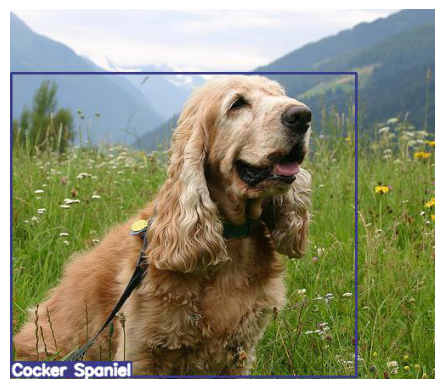

In [42]:
slide_name = 1

result_images = []

for idx in range(len(images)):
    image = images[idx]
    boxes = all_boxes[idx]
    classes = all_classes[idx]

    result_images.append(render_results(image, boxes, classes))

image_slider(result_images, slide_name=slide_name)

result_images = None

## Model

#### Basic inferance

In [43]:
# !pip uninstall ultralytics ray -y
# !pip install ultralytics
# !pip install 'ray[tune]'

# # Found existing installation: ultralytics 8.3.58
# # Uninstalling ultralytics-8.3.58:
# #   Successfully uninstalled ultralytics-8.3.58
# # Found existing installation: ray 2.4.0
# # Uninstalling ray-2.4.0:
# #   Successfully uninstalled ray-2.4.0

# # ray-2.40.0-cp310-cp310-manylinux2014_x86_64.whl
# # Successfully installed ray-2.40.0

In [44]:
# pip list | grep ultralytics

# # ultralytics                            8.3.58
# # ultralytics-thop                       2.0.13
# # Note: you may need to restart the kernel to use updated packages.

In [45]:
EPOCHS

35

In [46]:
# EPOCHS = 35

# # 本地环境 训练, 多卡的时候,记得使batch_size是GPU数量的倍数
# # ValueError: 'batch=16' must be a multiple of GPU count 3. Try 'batch=15' or 'batch=18', the nearest batch sizes evenly divisible by 3.

# # 方案1：在代码开头设置环境变量
# import os
# os.environ['MKL_THREADING_LAYER'] = 'GNU'

# # os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 使用第一个 GPU
# # # os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 或使用第二个 GPU

# # # 方案2：如果方案1不起作用，可以尝试强制使用 Intel 线程层
# # os.environ['MKL_SERVICE_FORCE_INTEL'] = '1'

# # # 方案3：确保 numpy 在 torch 之前导入
# # import numpy as np  # 必须在 import torch 之前
# # import torch

# # 或者在终端中运行训练脚本之前设置环境变量：
# # # 方案4：在终端中设置环境变量后运行
# # export MKL_THREADING_LAYER=GNU
# # python your_training_script.py

# # # 或者
# # export MKL_SERVICE_FORCE_INTEL=1
# # python your_training_script.py



BATCH_SIZE = BATCH_SIZE * num_devices

model_name = "yolov8m"
version = "v1"
experiment_name = f"{model_name}-{version}"
resume = False

if resume:
    # pass
    weight = f"{save_dir}/weights/last.pt"
    model = YOLO(weight)
    model.train(resume=True)
    
else:
    model = YOLO(model_name)

    # 训练参数设置可以查看 https://docs.ultralytics.com/modes/train/#train-settings
    model.train(
        data=dataset_yaml_path, 
        epochs=EPOCHS, 
        imgsz=IMAGE_SIZE, 
        batch=BATCH_SIZE,
        device=DEVICE,
        project=PROJECT_NAME,
        resume=resume,
        name=experiment_name,
        amp=True,
        exist_ok=True,
        patience = 15,
        save_period=5
        )


Ultralytics 8.3.58 🚀 Python-3.10.16 torch-2.5.1 CUDA:0 (CUDA GPU, 32501MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/home/work/test_data/detection/dataset.yaml, epochs=35, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=[0], workers=8, project=dog_breed_detection, name=yolov8m-v1, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/chg0901/dog-breed-detection/bf61359a2d1b4ced8281b54ae5d7fa1a

COMET INFO: Couldn't find a Git repository in '/home/work/test_data' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


/home/work/miniconda3/envs/yolo/lib/python3.10/site-packages/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


AMP: checks passed ✅


train: Scanning /home/work/test_data/data/new_yolo_stanford_dogs/train/labels... 14869 images, 0 backgrounds, 1 corrupt: 100%|██████████| 14869/14869 [00:13<00:00, 1062.93it/s]

train: WARNING ⚠️ /home/work/test_data/data/new_yolo_stanford_dogs/train/images/n02089973_1763.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /home/work/test_data/data/new_yolo_stanford_dogs/train/images/n02089973_2054.jpg: corrupt JPEG restored and saved
train: WARNING ⚠️ /home/work/test_data/data/new_yolo_stanford_dogs/train/images/n02106030_3948.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0278]


train: New cache created: /home/work/test_data/data/new_yolo_stanford_dogs/train/labels.cache


val: Scanning /home/work/test_data/data/new_yolo_stanford_dogs/val/labels... 2624 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2624/2624 [00:02<00:00, 1228.22it/s]


val: New cache created: /home/work/test_data/data/new_yolo_stanford_dogs/val/labels.cache
Plotting labels to dog_breed_detection/yolov8m-v1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=8.1e-05, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to dog_breed_detection/yolov8m-v1
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      6.85G     0.6621       4.04      1.252          8        640: 100%|██████████| 930/930 [04:12<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:23<00:00,  3.49it/s]


                   all       2624       2823      0.202      0.309      0.193      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      6.91G      0.633      2.659      1.194          7        640: 100%|██████████| 930/930 [04:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.60it/s]


                   all       2624       2823      0.424      0.487      0.452      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      7.04G     0.6255      2.191      1.179          8        640: 100%|██████████| 930/930 [03:55<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.60it/s]


                   all       2624       2823      0.458      0.525      0.513      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      6.93G      0.616      1.938       1.17         12        640: 100%|██████████| 930/930 [03:54<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:23<00:00,  3.53it/s]


                   all       2624       2823      0.546      0.605      0.621      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      6.88G     0.6022      1.744      1.157         16        640: 100%|██████████| 930/930 [03:54<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.60it/s]


                   all       2624       2823       0.63      0.624      0.683      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35       6.9G     0.5929      1.609      1.147         12        640: 100%|██████████| 930/930 [03:54<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.58it/s]

                   all       2624       2823       0.64      0.639      0.702      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35       6.9G     0.5768      1.513      1.136         13        640: 100%|██████████| 930/930 [03:53<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.62it/s]

                   all       2624       2823      0.649      0.666      0.732      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      6.91G     0.5676      1.416      1.129          8        640: 100%|██████████| 930/930 [03:59<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:17<00:00,  4.75it/s]


                   all       2624       2823      0.671      0.697      0.754      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35       6.9G     0.5638      1.363      1.125         10        640: 100%|██████████| 930/930 [04:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.62it/s]

                   all       2624       2823      0.707      0.699      0.763      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35       6.9G     0.5554      1.306       1.12         15        640: 100%|██████████| 930/930 [03:54<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.63it/s]

                   all       2624       2823      0.698      0.715      0.776      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      6.91G     0.5497      1.244      1.112          9        640: 100%|██████████| 930/930 [03:54<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.61it/s]

                   all       2624       2823      0.728      0.717      0.788      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      6.93G      0.539      1.198      1.108         10        640: 100%|██████████| 930/930 [03:54<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.61it/s]

                   all       2624       2823      0.744      0.741      0.808      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      6.91G     0.5365      1.155      1.105          8        640: 100%|██████████| 930/930 [03:54<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.61it/s]

                   all       2624       2823      0.747      0.741      0.806      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      6.92G     0.5268      1.113      1.099         11        640: 100%|██████████| 930/930 [03:55<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.63it/s]

                   all       2624       2823      0.754      0.747      0.816      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      6.91G     0.5212      1.069      1.092         12        640: 100%|██████████| 930/930 [03:54<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:20<00:00,  3.91it/s]

                   all       2624       2823      0.747      0.749      0.817      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      6.92G     0.5199      1.039       1.09         10        640: 100%|██████████| 930/930 [04:00<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:19<00:00,  4.28it/s]


                   all       2624       2823      0.754      0.762      0.826      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35       6.9G     0.5141      1.001      1.088          7        640: 100%|██████████| 930/930 [03:58<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:24<00:00,  3.35it/s]

                   all       2624       2823      0.785      0.762      0.829      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      6.92G     0.5044     0.9849      1.081         13        640: 100%|██████████| 930/930 [03:54<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.62it/s]

                   all       2624       2823      0.757      0.786      0.831       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      6.88G     0.5047      0.959      1.082         10        640: 100%|██████████| 930/930 [03:54<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.63it/s]

                   all       2624       2823      0.767      0.771      0.831      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      6.94G     0.4969     0.9251      1.076         15        640: 100%|██████████| 930/930 [03:55<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.64it/s]

                   all       2624       2823      0.783       0.77      0.834      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      6.89G     0.4941      0.905      1.072         14        640: 100%|██████████| 930/930 [03:54<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.59it/s]

                   all       2624       2823       0.77      0.792       0.84      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      6.93G     0.4894     0.8833       1.07         11        640: 100%|██████████| 930/930 [03:56<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:23<00:00,  3.43it/s]

                   all       2624       2823      0.788      0.774      0.842      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      6.89G     0.4844     0.8577      1.066          8        640: 100%|██████████| 930/930 [03:56<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:19<00:00,  4.23it/s]

                   all       2624       2823      0.799      0.775      0.845      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      6.92G       0.48     0.8368      1.064         13        640: 100%|██████████| 930/930 [04:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:21<00:00,  3.82it/s]


                   all       2624       2823      0.813      0.756      0.838      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35       6.9G     0.4719     0.8117      1.061         13        640: 100%|██████████| 930/930 [03:55<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.63it/s]

                   all       2624       2823      0.801      0.762      0.847      0.772


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      6.93G     0.2983     0.3716     0.9445          4        640: 100%|██████████| 930/930 [03:54<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.63it/s]

                   all       2624       2823      0.797      0.785      0.851      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35       6.9G     0.2916     0.3356      0.938          4        640: 100%|██████████| 930/930 [03:54<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.62it/s]

                   all       2624       2823      0.791      0.794      0.848      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      6.92G     0.2834     0.3092     0.9299          6        640: 100%|██████████| 930/930 [03:54<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.63it/s]

                   all       2624       2823      0.783      0.781      0.845      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      6.88G     0.2774     0.2883      0.926          4        640: 100%|██████████| 930/930 [03:53<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.64it/s]

                   all       2624       2823      0.794      0.766      0.844       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      6.91G     0.2746      0.273     0.9211          4        640: 100%|██████████| 930/930 [03:56<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:19<00:00,  4.23it/s]

                   all       2624       2823       0.78      0.783      0.839      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      6.89G     0.2682      0.253     0.9194          4        640: 100%|██████████| 930/930 [04:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:21<00:00,  3.85it/s]


                   all       2624       2823      0.785      0.771       0.84      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      6.92G     0.2628     0.2406     0.9166          4        640: 100%|██████████| 930/930 [03:56<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.65it/s]

                   all       2624       2823      0.781      0.796      0.843      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35       6.9G     0.2591     0.2295     0.9097          5        640: 100%|██████████| 930/930 [03:54<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:22<00:00,  3.63it/s]

                   all       2624       2823       0.78      0.785      0.842      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      6.91G     0.2571     0.2185     0.9087          7        640: 100%|██████████| 930/930 [03:53<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:23<00:00,  3.51it/s]

                   all       2624       2823      0.784       0.78      0.842       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35       6.9G     0.2524      0.209      0.907          4        640: 100%|██████████| 930/930 [03:54<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:23<00:00,  3.50it/s]

                   all       2624       2823      0.804      0.774      0.842       0.77



35 epochs completed in 2.534 hours.
Optimizer stripped from dog_breed_detection/yolov8m-v1/weights/last.pt, 52.1MB
Optimizer stripped from dog_breed_detection/yolov8m-v1/weights/best.pt, 52.1MB

Validating dog_breed_detection/yolov8m-v1/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.16 torch-2.5.1 CUDA:0 (CUDA GPU, 32501MiB)
Model summary (fused): 218 layers, 25,909,240 parameters, 0 gradients, 79.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:23<00:00,  3.54it/s]


                   all       2624       2823      0.803      0.781      0.851      0.775
         Affenpinscher         22         22      0.782      0.864      0.908       0.82
          Afghan Hound         24         26      0.966      0.923       0.98      0.945
   African Hunting Dog         25         28          1      0.822      0.957      0.837
              Airedale         31         33      0.758      0.855      0.783      0.745
American Staffordshire Terrier         17         18      0.626      0.778       0.74      0.721
           Appenzeller         23         24      0.615       0.75      0.748       0.65
    Australian Terrier         17         17      0.693      0.765      0.868      0.772
               Basenji         45         50      0.916       0.74      0.902      0.842
                Basset         20         20      0.785      0.911      0.879      0.794
                Beagle         25         26      0.729      0.692      0.799      0.707
    Bedlingto

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : potential_carp_7371
COMET INFO:     url                   : https://www.comet.com/chg0901/dog-breed-detection/bf61359a2d1b4ced8281b54ae5d7fa1a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3255]               : (586.6004028320312, 8367398.0)
COMET INFO:     lr/pg0 [36]               : (3.1011428571428582e-06, 7.639032442396314e-05)
COMET INFO:     lr/pg1 [36]               : (3.1011428571428582e-06, 7.639032442396314e-05)
COMET INFO:     lr/pg2 [36]               : (3.1011428571428582e-06, 7.639032442396314e-05)
COMET INFO:     metrics/mAP50(B) [36]     : (0.19323, 0.85134)
COMET INFO:     metrics/mAP50-95(B) [36]  : (0.17093, 0.775

In [70]:
!sudo apt install tree
!tree /home/work/test_data/dog_breed_detection/yolov8m-v1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.8.0-1).
0 upgraded, 0 newly installed, 0 to remove and 247 not upgraded.
/home/work/test_data/dog_breed_detection/yolov8m-v1
├── F1_curve.png
├── PR_curve.png
├── P_curve.png
├── R_curve.png
├── args.yaml
├── confusion_matrix.png
├── confusion_matrix_normalized.png
├── labels.jpg
├── labels_correlogram.jpg
├── results.csv
├── results.png
├── train_batch0.jpg
├── train_batch1.jpg
├── train_batch2.jpg
├── train_batch23250.jpg
├── train_batch23251.jpg
├── train_batch23252.jpg
├── val_batch0_labels.jpg
├── val_batch0_pred.jpg
├── val_batch1_labels.jpg
├── val_batch1_pred.jpg
├── val_batch2_labels.jpg
├── val_batch2_pred.jpg
└── weights
    ├── best.pt
    ├── epoch0.pt
    ├── epoch10.pt
    ├── epoch15.pt
    ├── epoch20.pt
    ├── epoch25.pt
    ├── epoch30.pt
    ├── epoch5.pt
    └── last.pt

1 directory, 32 files


In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def show_all_images_original_size(folder_path):
    """
    按原始大小显示文件夹中的所有图片
    Args:
        folder_path: 图片文件夹路径
    """
    # 获取所有图片文件
    image_files = [f for f in os.listdir(folder_path) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    image_files.sort()
    
    if not image_files:
        print(f"没有找到图片文件在: {folder_path}")
        return
    
    total_images = len(image_files)
    print(f"文件夹中共有 {total_images} 张图片")
    
    # 依次显示每张图片
    for idx, img_file in enumerate(image_files, 1):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        
        # 创建新的图形，使用图片原始大小
        dpi = plt.rcParams['figure.dpi']
        height, width = img.size
        plt.figure(figsize=(width/dpi, height/dpi))
        
        # 显示图片
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Images {idx}/{total_images}: {img_file}")
        plt.show()

training_images_folder = "/home/work/test_data/dog_breed_detection/yolov8m-v1"
# show_all_images_original_size(training_images_folder)

# 推理

In [5]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def show_folder_images(folder_path, figsize=(12, 8)):   
    """
    增强版图片浏览器，带更多控制选项
    """
    image_files = [f for f in os.listdir(folder_path) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    image_files.sort()
    
    if not image_files:
        print(f"没有找到图片文件在: {folder_path}")
        return
    
    # 创建控件
    slider = widgets.IntSlider(
        value=0, min=0, max=len(image_files)-1, step=1,
        description='图片索引:',
        continuous_update=False,
        layout=widgets.Layout(width='500px')
    )
    
    prev_button = widgets.Button(
        description='上一张',
        icon='arrow-left',
        layout=widgets.Layout(width='100px')
    )
    
    next_button = widgets.Button(
        description='下一张',
        icon='arrow-right',
        layout=widgets.Layout(width='100px')
    )
    
    first_button = widgets.Button(
        description='第一张',
        icon='fast-backward',
        layout=widgets.Layout(width='100px')
    )
    
    last_button = widgets.Button(
        description='最后一张',
        icon='fast-forward',
        layout=widgets.Layout(width='100px')
    )
    
    size_slider = widgets.FloatSlider(
        value=figsize[0],
        min=4,
        max=20,
        step=0.5,
        description='图片大小:',
        continuous_update=False
    )
    
    def show_image(index):
        clear_output(wait=True)
        plt.figure(figsize=(size_slider.value, size_slider.value*2/3))
        img_path = os.path.join(folder_path, image_files[index])
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Images {index+1}/{len(image_files)}: {image_files[index]}")
        plt.show()
        
        # 显示所有控件
        display(widgets.HBox([first_button, prev_button, slider, next_button, last_button]))
        display(size_slider)
        print(f"Current Index: {index+1}, Total {len(image_files)}")
    
    # 事件处理函数
    def on_value_change(change):
        show_image(change['new'])
    
    def on_prev_button_clicked(b):
        slider.value = max(0, slider.value - 1)
    
    def on_next_button_clicked(b):
        slider.value = min(len(image_files)-1, slider.value + 1)
    
    def on_first_button_clicked(b):
        slider.value = 0
    
    def on_last_button_clicked(b):
        slider.value = len(image_files)-1
    
    def on_size_change(change):
        show_image(slider.value)
    
    # 绑定事件
    slider.observe(on_value_change, names='value')
    size_slider.observe(on_size_change, names='value')
    prev_button.on_click(on_prev_button_clicked)
    next_button.on_click(on_next_button_clicked)
    first_button.on_click(on_first_button_clicked)
    last_button.on_click(on_last_button_clicked)
    
    # 显示第一张图片
    show_image(0)

# # 使用增强版
# show_folder_images_advanced(source)


In [53]:
from ultralytics import YOLO
# 加载训练好的模型，改为自己的路径
model = YOLO('/home/work/test_data/dog_breed_detection/yolov8m-v1/weights/best.pt')
# 修改为自己的图像或者文件夹的路径

# 测试图片可以自己下载或者从下面的网站获取https://www.vecteezy.com/free-photos/multiple-dogs

# source = '/home/work/test_data/dogs1.png' #修改为自己的图片路径及文件名
source = '/home/work/test_data/dog_breed_detection/test_dogs' #修改为自己的图片路径及文件名

# 运行推理，并附加参数
model.predict(source, save=True)  # default save_dir = runs/detect/predict{index}


image 1/2 /home/work/test_data/dog_breed_detection/test_dogs/dogs1.png: 416x640 1 Gordon Setter, 1 Greater Swiss Mountain Dog, 1 Labrador Retriever, 25.0ms
image 2/2 /home/work/test_data/dog_breed_detection/test_dogs/dogs2.png: 320x640 1 Curly Coated Retriever, 4 English Foxhounds, 3 Entlebuchers, 1 Siberian Husky, 1 Silky Terrier, 4 Standard Schnauzers, 1 West Highland White Terrier, 46.5ms
Speed: 4.9ms preprocess, 35.7ms inference, 4.7ms postprocess per image at shape (1, 3, 320, 640)
Results saved to runs/detect/predict4


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Affenpinscher', 1: 'Afghan Hound', 2: 'African Hunting Dog', 3: 'Airedale', 4: 'American Staffordshire Terrier', 5: 'Appenzeller', 6: 'Australian Terrier', 7: 'Basenji', 8: 'Basset', 9: 'Beagle', 10: 'Bedlington Terrier', 11: 'Bernese Mountain Dog', 12: 'Black And Tan Coonhound', 13: 'Blenheim Spaniel', 14: 'Bloodhound', 15: 'Bluetick', 16: 'Border Collie', 17: 'Border Terrier', 18: 'Borzoi', 19: 'Boston Bull', 20: 'Bouvier Des Flandres', 21: 'Boxer', 22: 'Brabancon Griffon', 23: 'Briard', 24: 'Brittany Spaniel', 25: 'Bull Mastiff', 26: 'Cairn', 27: 'Cardigan', 28: 'Chesapeake Bay Retriever', 29: 'Chihuahua', 30: 'Chow', 31: 'Clumber', 32: 'Cocker Spaniel', 33: 'Collie', 34: 'Curly Coated Retriever', 35: 'Dandie Dinmont', 36: 'Dhole', 37: 'Dingo', 38: 'Doberman', 39: 'English Foxhound', 40: 'English Setter', 41: 'English Springer', 42:

In [2]:
# 展示原图
# source = 'dog_breed_detection/test_dogs'

# 使用增强版
# show_folder_images_advanced(source)
# show_folder_images(source)

In [3]:
# 展示预测后的图片
predictions = "/home/work/test_data/runs/detect/predict4"
# show_folder_images(predictions)

In [4]:
# 也可以用这种方式逐一查看training_images_folder中的图片
training_images_folder = '/home/work/test_data/dog_breed_detection/yolov8m-v1'
# show_folder_images(training_images_folder)